__Uplift Modelling__
Suppose you are about to launch a promotional campaign and you know which segment to target. Then we don't need to send offer to
everyone.In your current segment there will be customers who would buy anyways. We can segment customers based on this approach 
in four groups:-
- __Treatment Responders__- Customers who will purchase only if they will get an offer.
- __Treatment Non-Responder__ - Customers who will not purchase purchase in any case.
- __Control Responders__ - Customers who will purchase without an offer
- __Control Non Responders__ - Customers who will not purchase if they don't receive an offer.

We need to target Treatment Responders(TR) and Control Non Responders(CNR) as they will not buy without an offer. These segments
will help in boosting the uplift in your promotional campaigns. Whereas Targeting Treatment Non Responders(TNR) and Control 
Responders(CR) will cannabilize your promotional campaign.

There is one last simple thing to do. We need to identify which customers fall into which buckets. The answer is Uplift Modeling. It has two simple steps:
- Predict the probabilities of being in each group for all customers: we are going to build a multi-classification model for that.
- We will calculate the uplift score. Uplift score formula is:


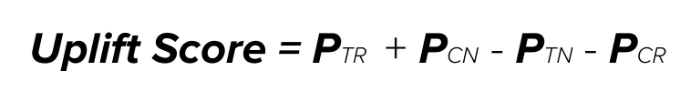
We will sum up the probability of being TR and CN and subtract the probability of falling into other buckets. The higher score means higher uplift.

In [19]:
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
import sklearn
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import xgboost as xgb

In [8]:
#function to order clusters
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [9]:
def calc_uplift(df):
    avg_order_value = 25
    
    #calculate conversions for each offer type
    base_conv = df[df.offer == 'No Offer']['conversion'].mean()
    disc_conv = df[df.offer == 'Discount']['conversion'].mean()
    bogo_conv = df[df.offer == 'Buy One Get One']['conversion'].mean()
    
    #calculate conversion uplift for discount and bogo
    disc_conv_uplift = disc_conv - base_conv
    bogo_conv_uplift = bogo_conv - base_conv
    
    #calculate order uplift
    disc_order_uplift = disc_conv_uplift * len(df[df.offer == 'Discount']['conversion'])
    bogo_order_uplift = bogo_conv_uplift * len(df[df.offer == 'Buy One Get One']['conversion'])
    
    #calculate revenue uplift
    disc_rev_uplift = disc_order_uplift * avg_order_value
    bogo_rev_uplift = bogo_order_uplift * avg_order_value
    
    
    print('Discount Conversion Uplift: {0}%'.format(np.round(disc_conv_uplift*100,2)))
    print('Discount Order Uplift: {0}'.format(np.round(disc_order_uplift,2)))
    print('Discount Revenue Uplift: ${0}\n'.format(np.round(disc_rev_uplift,2)))
    
    if len(df[df.offer == 'Buy One Get One']['conversion']) > 0:
          
        print('-------------- \n')
        print('BOGO Conversion Uplift: {0}%'.format(np.round(bogo_conv_uplift*100,2)))
        print('BOGO Order Uplift: {0}'.format(np.round(bogo_order_uplift,2)))
        print('BOGO Revenue Uplift: ${0}'.format(np.round(bogo_rev_uplift,2)))   

In [10]:
df_data = pd.read_csv('data.csv')
df_data.head(10)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0
5,6,134.83,0,1,Surburban,0,Phone,Buy One Get One,1
6,9,280.20,1,0,Surburban,1,Phone,Buy One Get One,0
7,9,46.42,0,1,Urban,0,Phone,Buy One Get One,0
8,9,675.07,1,1,Rural,1,Phone,Discount,0
9,10,32.84,0,1,Urban,1,Web,Buy One Get One,0


Column descriptions are as follows:
- recency: months since last purchase
- history: $value of the historical purchases
- used_discount/used_bogo: indicates if the customer used a discount or buy one get one before
- zip_code: class of the zip code as Suburban/Urban/Rural
- is_referral: indicates if the customer was acquired from referral channel
- channel: channels that the customer using, Phone/Web/Multichannel
- offer: the offers sent to the customers, Discount/But One Get One/No Offer- - 

In [11]:
calc_uplift(df_data)

Discount Conversion Uplift: 7.66%
Discount Order Uplift: 1631.89
Discount Revenue Uplift: $40797.35

-------------- 

BOGO Conversion Uplift: 4.52%
BOGO Order Uplift: 967.4
BOGO Revenue Uplift: $24185.01


__Multi Classification Model__
Currently, our label is if a customer converted or not (1 or 0). We need to create four classes for TR, TN, CR, and CN. We 
know that the customers who received discount and bogo offers are Treatment and the rest is control. Let’s create a 
campaign_group column make this info visible:

In [12]:
df_data['campaign_group'] = 'treatment'
df_data.loc[df_data.offer == 'No Offer', 'campaign_group'] = 'control'

In [13]:
df_data['target_class'] = 0 #CN
df_data.loc[(df_data.campaign_group == 'control') & (df_data.conversion > 0),'target_class'] = 1 #CR
df_data.loc[(df_data.campaign_group == 'treatment') & (df_data.conversion == 0),'target_class'] = 2 #TN
df_data.loc[(df_data.campaign_group == 'treatment') & (df_data.conversion > 0),'target_class'] = 3 #TR

In this example, the mapping of the classes are below:
- 0 -> Control Non-Responders
- 1 -> Control Responders
- 2 -> Treatment Non-Responders
- 3 -> Treatment Responders

In [14]:
#creating the clusters
kmeans = KMeans(n_clusters=5)
kmeans.fit(df_data[['history']])
df_data['history_cluster'] = kmeans.predict(df_data[['history']])
#order the clusters
df_data = order_cluster('history_cluster', 'history',df_data,True)
#creating a new dataframe as model and dropping columns that defines the label
df_model = df_data.drop(['offer','campaign_group','conversion'],axis=1)
#convert categorical columns
df_model = pd.get_dummies(df_model)

In [15]:
df_model.head()

,recency,history,used_discount,used_bogo,is_referral,target_class,history_cluster,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
0,10,142.44,1,0,0,2,0,0,1,0,0,1,0
1,2,45.34,1,0,0,2,0,0,0,1,0,0,1
2,6,134.83,0,1,0,3,0,0,1,0,0,1,0
3,9,46.42,0,1,0,2,0,0,0,1,0,1,0
4,10,32.84,0,1,1,2,0,0,0,1,0,0,1


In [16]:
#create feature set and labels
X = df_model.drop(['target_class'],axis=1)
y = df_model.target_class

In [17]:
X.columns

Index(['recency', 'history', 'used_discount', 'used_bogo', 'is_referral',
       'history_cluster', 'zip_code_Rural', 'zip_code_Surburban',
       'zip_code_Urban', 'channel_Multichannel', 'channel_Phone',
       'channel_Web'],
      dtype='object')

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=56)
xgb_model = xgb.XGBClassifier().fit(X_train, y_train)
class_probs = xgb_model.predict_proba(X_test)

In [21]:
class_probs[0]

array([0.33018395, 0.01280369, 0.597153  , 0.05985933], dtype=float32)

In [22]:
X_test['proba_CN'] = class_probs[:,0] 
X_test['proba_CR'] = class_probs[:,1] 
X_test['proba_TN'] = class_probs[:,2] 
X_test['proba_TR'] = class_probs[:,3]

C:\Users\Mehul Sharma\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Mehul Sharma\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Mehul Sharma\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

In [23]:
X_test['uplift_score'] = X_test.eval('proba_CN + proba_TR - proba_TN - proba_CR')

C:\Users\Mehul Sharma\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [24]:
X_test.head()

,recency,history,used_discount,used_bogo,is_referral,history_cluster,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score
32277,6,29.99,1,0,1,0,0,0,1,0,1,0,0.330184,0.012804,0.597153,0.059859,-0.219913
12824,8,29.99,0,1,0,0,1,0,0,0,0,1,0.264175,0.046504,0.552342,0.136978,-0.197693
20159,7,134.66,1,0,0,0,0,1,0,0,1,0,0.309038,0.037251,0.569651,0.084061,-0.213802
41575,3,195.55,0,1,0,1,0,0,1,0,0,1,0.282702,0.047076,0.535739,0.134483,-0.165631
10736,10,29.99,1,0,0,0,0,1,0,0,0,1,0.308182,0.037957,0.557303,0.096558,-0.190520


In [25]:
overall_proba = xgb_model.predict_proba(df_model.drop(['target_class'],axis=1))

In [26]:
df_model['proba_CN'] = overall_proba[:,0] 
df_model['proba_CR'] = overall_proba[:,1] 
df_model['proba_TN'] = overall_proba[:,2] 
df_model['proba_TR'] = overall_proba[:,3]

In [27]:
df_model['uplift_score'] = df_model.eval('proba_CN + proba_TR - proba_TN - proba_CR')

In [28]:
df_data['uplift_score'] = df_model['uplift_score']

In [29]:
df_data.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion,campaign_group,target_class,history_cluster,uplift_score
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0,treatment,2,0,-0.204294
1,2,45.34,1,0,Urban,0,Web,Buy One Get One,0,treatment,2,0,-0.149471
2,6,134.83,0,1,Surburban,0,Phone,Buy One Get One,1,treatment,3,0,-0.170402
3,9,46.42,0,1,Urban,0,Phone,Buy One Get One,0,treatment,2,0,-0.179062
4,10,32.84,0,1,Urban,1,Web,Buy One Get One,0,treatment,2,0,-0.227502


In [30]:
df_data.groupby('offer').uplift_score.mean()

offer
Buy One Get One   -0.182591
Discount          -0.181935
No Offer          -0.178105
Name: uplift_score, dtype: float32

In [31]:
df_data_lift = df_data.copy()
uplift_q_75 = df_data_lift.uplift_score.quantile(0.75)
df_data_lift = df_data_lift[(df_data_lift.offer != 'Buy One Get One') & (df_data_lift.uplift_score > uplift_q_75)].reset_index(drop=True)

In [32]:
len(df_data_lift)

10868

In [33]:
calc_uplift(df_data_lift)

Discount Conversion Uplift: 12.55%
Discount Order Uplift: 661.51
Discount Revenue Uplift: $16537.67



In [34]:
df_data_lift = df_data.copy()
uplift_q_5 = df_data_lift.uplift_score.quantile(0.5)
df_data_lift = df_data_lift[(df_data_lift.offer != 'Buy One Get One') & (df_data_lift.uplift_score < uplift_q_5)].reset_index(drop=True)

In [35]:
calc_uplift(df_data_lift)

Discount Conversion Uplift: 5.45%
Discount Order Uplift: 588.78
Discount Revenue Uplift: $14719.42

